After having obtained a fine-tuned student model, we now want to evaluate its performance on the non-augmented test set and compare it to the teacher model's performance.

For this purpose, we would like to compare the predictive distribution for input samples (preferably from the test set) of the teacher and student model. We can then compare the two distributions visually and quantitatively using the Kullback-Leibler divergence.

In [79]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from src.utils.data import Dataset
from src.utils.inference import mc_dropout_predict
from src.data.robustness_study.bert_data_preprocessing import bert_preprocess, get_tf_dataset
from src.models.bert_model import AleatoricMCDropoutBERT, create_bert_config
from src.utils.loss_functions import aleatoric_loss, null_loss

In [3]:
# load and preprocess test data
df_test = pd.read_csv('../data/robustness_study/preprocessed/test.csv', sep='\t', index_col=0)
df_test.head()

,text,target
0,in class still drunk from last night and this ...,1
1,sighs of relief from beijing guoan fans <hasht...,0
2,<user> <user> <user> they do why else do teach...,1
3,preparing to be called a nigger all night i me...,1
4,rt <user> we dont love these hoes <url>,1


In [4]:
MAX_LENGTH = 48
BATCH_SIZE = 16

dataset = Dataset()
dataset.test = df_test

subset_size = 25
dataset.test = dataset.test.sample(n=min(subset_size, len(dataset.test)), random_state=42)

tokenized_dataset = {
    'test': bert_preprocess(dataset.test, max_length=MAX_LENGTH)
}
test_data = get_tf_dataset(tokenized_dataset, 'test')
test_data = test_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [5]:
# load and initialize teacher model
TEACHER_PATH = '../out/bert_teacher/final_hd030_ad020_cd035/model'

with open(os.path.join(TEACHER_PATH, 'config.json'), 'r') as f:
    teacher_config = json.load(f)
    
config = create_bert_config(teacher_config['hidden_dropout_prob'],
                            teacher_config['attention_probs_dropout_prob'],
                            teacher_config['classifier_dropout'])

teacher = AleatoricMCDropoutBERT(config=config, custom_loss_fn=aleatoric_loss)
checkpoint_path = os.path.join(TEACHER_PATH, 'cp-{epoch:02d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print("Loading weights from", checkpoint_dir)
    teacher.load_weights(latest_checkpoint)

teacher.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss={'classifier': aleatoric_loss, 'log_variance': null_loss},
        metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        run_eagerly=True
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Loading weights from ../out/bert_teacher/final_hd030_ad020_cd035/model


In [6]:
# load and initialize student model
STUDENT_PATH = '../out/bert_student/aleatoric_and_epistemic/m5_k5/2epochs/model'

with open(os.path.join(STUDENT_PATH, 'config.json'), 'r') as f:
    student_config = json.load(f)
    
config = create_bert_config(teacher_config['hidden_dropout_prob'],
                            teacher_config['attention_probs_dropout_prob'],
                            teacher_config['classifier_dropout'])

student = AleatoricMCDropoutBERT(config=config, custom_loss_fn=aleatoric_loss)
checkpoint_path = os.path.join(STUDENT_PATH, 'cp-{epoch:02d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print("Loading weights from", checkpoint_dir)
    student.load_weights(latest_checkpoint)
    
student.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss={'classifier': aleatoric_loss, 'log_variance': null_loss},
        metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        run_eagerly=True
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Loading weights from ../out/bert_student/aleatoric_and_epistemic/m5_k5/2epochs/model


##### Test set evaluation: WA and MCD

In [7]:
from src.training.train_bert_teacher import compute_metrics, compute_mc_dropout_metrics
from src.distribution_distillation.uncertainty_distillation import compute_student_metrics, compute_student_mc_dropout_metrics

In [8]:
### weight averaging

In [9]:
# evaluate teacher model on test set
teacher_metrics_wa = compute_metrics(teacher, test_data)

In [10]:
teacher_metrics_wa.keys()

dict_keys(['y_true', 'y_pred', 'y_prob', 'variance', 'average_inference_time', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'nll_score', 'brier_score', 'ece_score'])

In [11]:
teacher_metrics_wa['f1_score']

0.9787234042553191

In [12]:
# evaluate student model on test set
student_metrics_wa = compute_metrics(student, test_data)

In [13]:
student_metrics_wa['f1_score']

0.9787234042553191

In [14]:
### mc dropout

In [24]:
teacher_metrics_mcd = compute_mc_dropout_metrics(teacher, test_data, n=20)

In [25]:
teacher_metrics_mcd.keys()

dict_keys(['y_true', 'y_pred', 'y_prob', 'variance', 'total_uncertainty', 'average_inference_time', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'nll_score', 'brier_score', 'avg_pred_entropy_score', 'ece_score'])

In [26]:
teacher_metrics_mcd['f1_score']

0.9787234042553191

In [27]:
teacher_metrics_mcd['average_inference_time']

962.7158451080322

In [28]:
np.mean(teacher_metrics_mcd['total_uncertainty']), teacher_metrics_mcd['avg_pred_entropy_score']

(0.3001903396844864, 0.09715518355369568)

In [29]:
student_metrics_mcd = compute_student_mc_dropout_metrics(student, test_data, n=20)

In [30]:
student_metrics_mcd['f1_score']

0.9583333333333334

In [31]:
student_metrics_mcd['average_inference_time']

115.55851936340332

In [32]:
np.mean(student_metrics_mcd['total_uncertainty']), student_metrics_mcd['avg_pred_entropy_score']

(0.25594785749912263, 0.8029887080192566)

##### Test set evaluation: Predictive distribution

In [69]:
# for some test sequences, save mc dropout predictive samples (all samples, as well as mean and variance), aleatoric and epistemic uncertainty (epistemic as total uncertainty - aleatoric)
def get_student_predictive_distribution_info(model, eval_data, n=20, num_samples=500):
    eval_data = eval_data.unbatch().take(num_samples).batch(32)
    
    total_logits = []
    total_mean_logits = []  # mean prediction (logit space)
    total_mean_variances = []  # aleatoric uncertainty
    total_variances = []  # epistemic uncertainty (?) - variance of predictive distribution
    total_labels = []
    total_uncertainties = []

    for batch in eval_data:
        features, labels = batch
        outputs = model.cached_mc_dropout_predict(features, n=n)
        logits = outputs['logits']
        mean_predictions = outputs['mean_predictions']
        mean_variances = outputs['mean_variances']
        var_predictions = outputs['var_predictions']
        total_uncertainty = outputs['total_uncertainty']
        total_logits.append(logits.numpy())
        total_mean_logits.extend(mean_predictions.numpy())
        total_mean_variances.extend(mean_variances.numpy())
        total_variances.extend(var_predictions.numpy())
        total_uncertainties.extend(total_uncertainty.numpy())
        total_labels.extend(labels.numpy())
        
    total_logits = np.concatenate(total_logits, axis=1)  
    transposed_logits = list(zip(*total_logits))
    transposed_logits = [item for item in transposed_logits]
    # Convert each tuple of arrays into a single list of raw values
    transposed_logits_raw = [ [value for array in tup for value in array.tolist()] for tup in transposed_logits ]
    
    if total_mean_logits and total_labels:
        all_labels = np.array(total_labels)
        mean_prob_predictions_np = tf.nn.sigmoid(total_mean_logits).numpy().reshape(all_labels.shape)
        mean_class_predictions_np = mean_prob_predictions_np.round(0).astype(int)
        mean_variances_np = np.array(total_mean_variances).reshape(all_labels.shape)
        total_uncertainties_np = np.array(total_uncertainties).reshape(all_labels.shape)
        labels_np = all_labels

        return {
            "logits": transposed_logits_raw,
            "y_true": labels_np.astype(int).tolist(),
            "y_pred": mean_class_predictions_np.tolist(),
            "y_prob": mean_prob_predictions_np.tolist(),
            "aleatoric_uncertainty": mean_variances_np.tolist(),
            "epistemic_uncertainty": (total_uncertainties_np - mean_variances_np).tolist(),
            "total_uncertainty": total_uncertainties_np.tolist()
        }
    
student_predictive_dist_info = get_student_predictive_distribution_info(student, test_data, n=20, num_samples=25)

In [72]:
# for some test sequences, save mc dropout predictive samples (all samples, as well as mean and variance), aleatoric and epistemic uncertainty (epistemic as total uncertainty - aleatoric)
def get_teacher_predictive_distribution_info(model, eval_data, n=20, num_samples=500) -> dict:
    eval_data = eval_data.unbatch().take(num_samples).batch(32)
    
    total_logits = []
    total_mean_logits = []  # mean prediction (logit space)
    total_mean_variances = []  # aleatoric uncertainty
    total_variances = []  # epistemic uncertainty (?) - variance of predictive distribution
    total_labels = []
    total_uncertainties = []

    for batch in eval_data:
        features, labels = batch
        logits, mean_variances, mean_predictions, var_predictions, total_uncertainty = mc_dropout_predict(model, features, n=n)
        total_logits.append(logits.numpy())
        total_mean_variances.extend(mean_variances.numpy())
        total_mean_logits.extend(mean_predictions.numpy())
        total_variances.extend(var_predictions.numpy())
        total_uncertainties.extend(total_uncertainty.numpy())
        total_labels.extend(labels.numpy())
        
    total_logits = np.concatenate(total_logits, axis=1)  
    transposed_logits = list(zip(*total_logits))
    transposed_logits = [item for item in transposed_logits]
    # Convert each tuple of arrays into a single list of raw values
    transposed_logits_raw = [ [value for array in tup for value in array.tolist()] for tup in transposed_logits ]
    
    if total_mean_logits and total_labels:
        all_labels = np.array(total_labels)
        mean_prob_predictions_np = tf.nn.sigmoid(total_mean_logits).numpy().reshape(all_labels.shape)
        mean_class_predictions_np = mean_prob_predictions_np.round(0).astype(int)
        mean_variances_np = np.array(total_mean_variances).reshape(all_labels.shape)
        total_uncertainties_np = np.array(total_uncertainties).reshape(all_labels.shape)
        labels_np = all_labels

        return {
            "logits": transposed_logits_raw,
            "y_true": labels_np.astype(int).tolist(),
            "y_pred": mean_class_predictions_np.tolist(),
            "y_prob": mean_prob_predictions_np.tolist(),
            "aleatoric_uncertainty": mean_variances_np.tolist(),
            "epistemic_uncertainty": (total_uncertainties_np - mean_variances_np).tolist(),
            "total_uncertainty": total_uncertainties_np.tolist()
        }
    
teacher_predictive_dist_info = get_teacher_predictive_distribution_info(student, test_data, n=20, num_samples=25)

In [75]:
with open(os.path.join('../tests/analysis', 'teacher_predictive_distribution.json'), 'w') as f:
    json.dump(teacher_predictive_dist_info, f)

In [76]:
with open(os.path.join('../tests/analysis', 'student_predictive_distribution.json'), 'w') as f:
    json.dump(student_predictive_dist_info, f)

#### Visualize predictive distribution

In [ ]:
# see what the predictive distribution looks like for some samples

# load predictive distribution info
with open(os.path.join('../tests/analysis', 'teacher_predictive_distribution.json'), 'r') as f:
    teacher_predictive_dist_info = json.load(f)
    
with open(os.path.join('../tests/analysis', 'student_predictive_distribution.json'), 'r') as f:
    student_predictive_dist_info = json.load(f)
    


In [80]:
# plot predictive distribution for some samples
def plot_predictive_distribution(teacher_predictive_dist_info, student_predictive_dist_info, sample_idx):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Predictive distribution for sample {sample_idx}")
    
    # teacher
    teacher_logits = teacher_predictive_dist_info['logits'][sample_idx]
    teacher_y_true = teacher_predictive_dist_info['y_true'][sample_idx]
    teacher_y_pred = teacher_predictive_dist_info['y_pred'][sample_idx]
    teacher_y_prob = teacher_predictive_dist_info['y_prob'][sample_idx]
    teacher_aleatoric_uncertainty = teacher_predictive_dist_info['aleatoric_uncertainty'][sample_idx]
    teacher_epistemic_uncertainty = teacher_predictive_dist_info['epistemic_uncertainty'][sample_idx]
    teacher_total_uncertainty = teacher_predictive_dist_info['total_uncertainty'][sample_idx]
    
    ax[0].hist(teacher_logits, bins=20)
    ax[0].set_title("Teacher predictive distribution")
    ax[0].set_xlabel("Logits")
    ax[0].set_ylabel("Frequency")
    
    # student
    student_logits = student_predictive_dist_info['logits'][sample_idx]
    student_y_true = student_predictive_dist_info['y_true'][sample_idx]
    student_y_pred = student_predictive_dist_info['y_pred'][sample_idx]
    student_y_prob = student_predictive_dist_info['y_prob'][sample_idx]
    student_aleatoric_uncertainty = student_predictive_dist_info['aleatoric_uncertainty'][sample_idx]
    student_epistemic_uncertainty = student_predictive_dist_info['epistemic_uncertainty'][sample_idx]
    student_total_uncertainty = student_predictive_dist_info['total_uncertainty'][sample_idx]
    
    ax[1].hist(student_logits, bins=20)
    ax[1].set_title("Student predictive distribution")
    ax[1].set_xlabel("Logits")
    ax[1].set_ylabel("Frequency")
    
    plt.show()
    
    print(f"Teacher: y_true={teacher_y_true}, y_pred={teacher_y_pred}, y_prob={teacher_y_prob}, aleatoric_uncertainty={teacher_aleatoric_uncertainty}, epistemic_uncertainty={teacher_epistemic_uncertainty}, total_uncertainty={teacher_total_uncertainty}")
    print(f"Student: y_true={student_y_true}, y_pred={student_y_pred}, y_prob={student_y_prob}, aleatoric_uncertainty={student_aleatoric_uncertainty}, epistemic_uncertainty={student_epistemic_uncertainty}, total_uncertainty={student_total_uncertainty}")

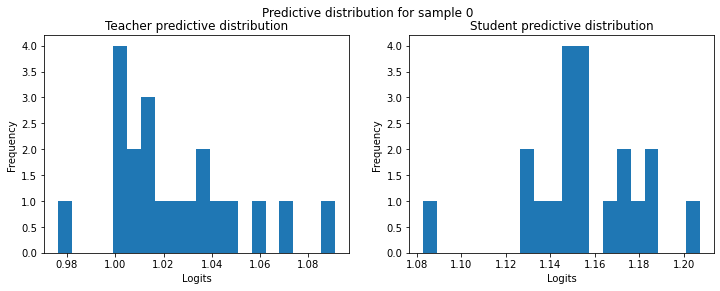

Teacher: y_true=1, y_pred=1, y_prob=0.7357932329177856, aleatoric_uncertainty=0.2881074845790863, epistemic_uncertainty=0.0007064342498779297, total_uncertainty=0.28881391882896423
Student: y_true=1, y_pred=1, y_prob=0.7604193687438965, aleatoric_uncertainty=0.2470196783542633, epistemic_uncertainty=0.0006642341613769531, total_uncertainty=0.24768391251564026


In [81]:
plot_predictive_distribution(teacher_predictive_dist_info, student_predictive_dist_info, sample_idx=0)

In [83]:
# find teacher idx with highest total uncertainty
teacher_total_uncertainty = teacher_predictive_dist_info['total_uncertainty']
teacher_total_uncertainty = np.array(teacher_total_uncertainty)
teacher_total_uncertainty.shape

(25,)

In [ ]:
teacher_total_uncertainty.argmax()

In [ ]:
# find corresponding student output
student_predictive_dist_info['total_uncertainty'][teacher_total_uncertainty.argmax()]

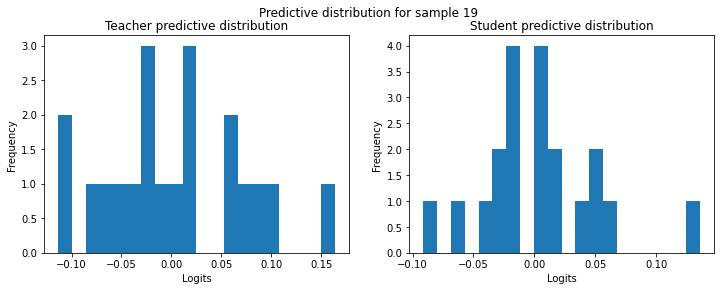

Teacher: y_true=0, y_pred=1, y_prob=0.5009537935256958, aleatoric_uncertainty=0.4696027934551239, epistemic_uncertainty=0.005046099424362183, total_uncertainty=0.4746488928794861
Student: y_true=0, y_pred=1, y_prob=0.50090092420578, aleatoric_uncertainty=0.4353446066379547, epistemic_uncertainty=0.0022932887077331543, total_uncertainty=0.43763789534568787


In [84]:
# plot predictive distribution for sample with highest total uncertainty
plot_predictive_distribution(teacher_predictive_dist_info, student_predictive_dist_info, sample_idx=teacher_total_uncertainty.argmax())